In [19]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

os.listdir("/kaggle/input/skin-cancer-malignant-vs-benign")

os.listdir("/kaggle/input/skin-cancer-malignant-vs-benign/train")

ben_dir = "/kaggle/input/skin-cancer-malignant-vs-benign/train/benign"
malig_dir = "/kaggle/input/skin-cancer-malignant-vs-benign/train/malignant"

train_dir = "/kaggle/input/skin-cancer-malignant-vs-benign/train"
test_dir = "/kaggle/input/skin-cancer-malignant-vs-benign/test"

print("Number of images in benign folder:",len(os.listdir("/kaggle/input/skin-cancer-malignant-vs-benign/train/benign")))
print("Number of images in malignant folder:",len(os.listdir("/kaggle/input/skin-cancer-malignant-vs-benign/train/malignant")))

Number of images in benign folder: 1440
Number of images in malignant folder: 1197


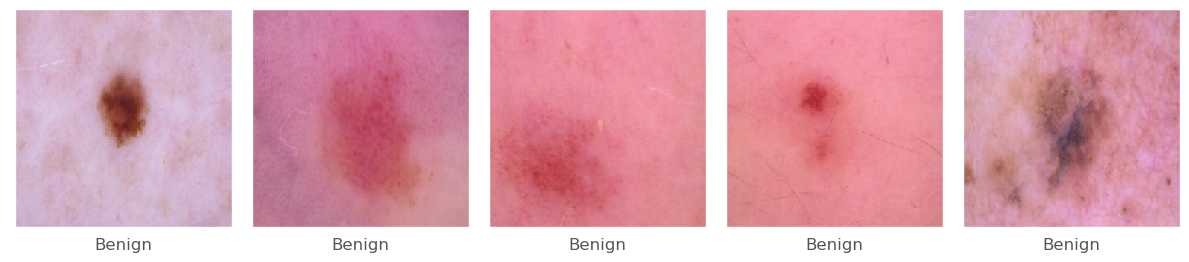

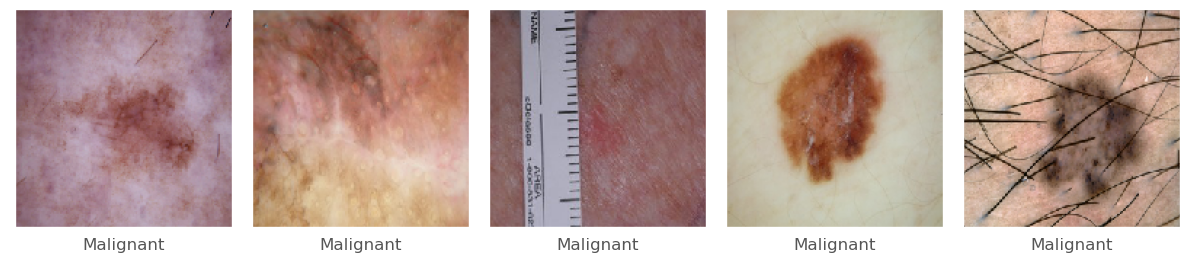

In [20]:
import random
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.image import load_img
plt.figure(figsize=(12,7))
ben = random.sample(os.listdir(ben_dir),5)
malig = random.sample(os.listdir(malig_dir),5)

for i,img in enumerate(ben):
    path = os.path.join(ben_dir,img)
    img = load_img(path, target_size=(150,150))
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.xlabel("Benign")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout();

plt.figure(figsize=(12,7))
for i,img in enumerate(malig):
    path = os.path.join(malig_dir,img)
    img = load_img(path, target_size=(150,150))
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.xlabel("Malignant")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout();

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale =(1./255),rotation_range=0.2,
    width_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    fill_mode='nearest',
    horizontal_flip= True)

val_datagen = ImageDataGenerator(rescale =(1./255))

train_data = train_datagen.flow_from_directory(directory = train_dir, 
                                               target_size =(224,224),
                                               class_mode = "categorical",
                                               batch_size =32)
test_data = val_datagen.flow_from_directory(directory = test_dir, 
                                               target_size =(224,224),
                                               class_mode = "categorical",
                                               batch_size =32)


Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


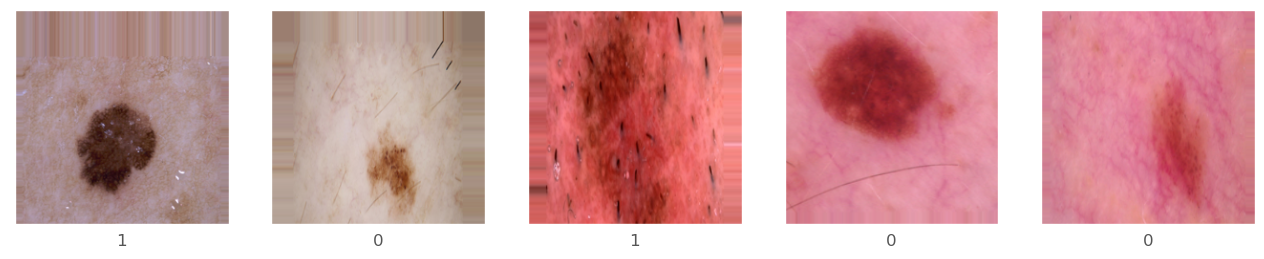

In [22]:
from tensorflow.keras.preprocessing import image
sample_x, sample_y = next(train_data)
plt.figure(figsize=(16,9))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = image.img_to_array(sample_x[i])
    plt.imshow(img)
    plt.xlabel(np.argmax(sample_y[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()


In [23]:
from tensorflow.keras.applications import InceptionV3

In [24]:
dense = InceptionV3(weights = "imagenet", include_top = False, input_shape=(224,224,3))

In [25]:
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization

model = Sequential()
model.add(dense)
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512,activation= "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "sigmoid"))

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 2, 2, 2048)       0         
 g2D)                                                            
                                                                 
 batch_normalization_190 (Ba  (None, 2, 2, 2048)       8192      
 tchNormalization)                                               
                                                                 
 dropout_4 (Dropout)         (None, 2, 2, 2048)        0         
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 512)              

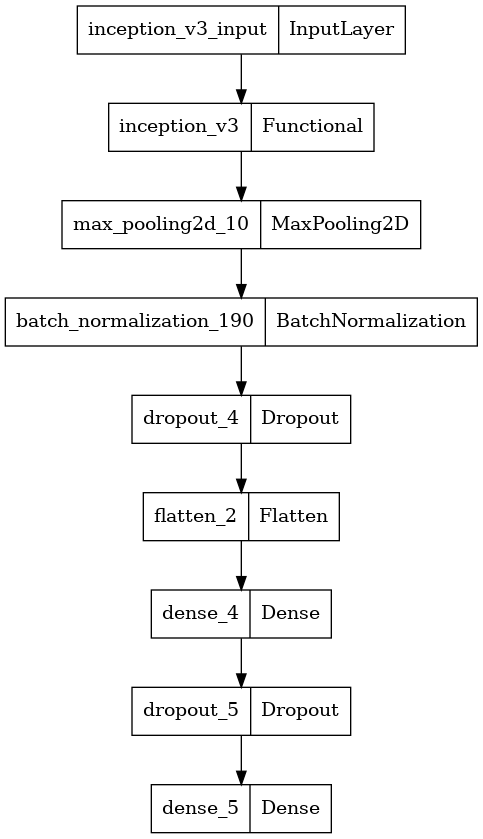

In [27]:
plot_model(model,
    to_file='InceptionV3.png',
    show_shapes=False,
    show_layer_names=True)

In [28]:
!pip install tensorflow-addons==0.16.1
import tensorflow_addons as tfa
from tensorflow.keras import metrics
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.metrics import MatthewsCorrelationCoefficient
metrics = ['accuracy',
           metrics.Precision(name='precision'),
           metrics.Recall(name='recall'),
           F1Score(num_classes = 2,name = 'f1'),
           MatthewsCorrelationCoefficient(num_classes = 2,name='mc'),
           tf.keras.metrics.TruePositives(name= 'tp'),
           tf.keras.metrics.TrueNegatives(name = 'tn'),
           tf.keras.metrics.FalseNegatives(name = 'fn'),
           tf.keras.metrics.FalsePositives(name = 'fp')
          ]

In [29]:
lr=0.0001
model.compile(optimizer = Adam(lr = 0.0001), loss = "categorical_crossentropy", metrics = metrics)

In [30]:
patience = 1
stop_patience = 3
factor = 0.5
#    tf.keras.callbacks.EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1),
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("InceptionV3.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1)
]

In [31]:
history = model.fit(train_data, validation_data = test_data, epochs = 30, 
                    verbose = 1, callbacks = callbacks )

Epoch 1/30


2023-03-22 04:51:47.866910: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


83/83 [==============================] - 77s 536ms/step - loss: 1.5911 - accuracy: 0.6860 - precision: 0.6169 - recall: 0.7763 - f1: 0.6835 - mc: 0.3652 - tp: 2047.0000 - tn: 1366.0000 - fn: 590.0000 - fp: 1271.0000 - val_loss: 465044736.0000 - val_accuracy: 0.4545 - val_precision: 0.4545 - val_recall: 0.4545 - val_f1: 0.3125 - val_mc: 0.0000e+00 - val_tp: 300.0000 - val_tn: 300.0000 - val_fn: 360.0000 - val_fp: 360.0000 - lr: 0.0010
Epoch 2/30
83/83 [==============================] - 46s 555ms/step - loss: 3.8690 - accuracy: 0.6117 - precision: 0.5746 - recall: 0.5563 - f1: 0.6062 - mc: 0.2126 - tp: 1467.0000 - tn: 1551.0000 - fn: 1170.0000 - fp: 1086.0000 - val_loss: 108830176.0000 - val_accuracy: 0.4545 - val_precision: 0.4545 - val_recall: 0.4545 - val_f1: 0.3125 - val_mc: 0.0000e+00 - val_tp: 300.0000 - val_tn: 300.0000 - val_fn: 360.0000 - val_fp: 360.0000 - lr: 0.0010
Epoch 3/30
83/83 [==============================] - 44s 524ms/step - loss: 1.2358 - accuracy: 0.7016 - precision

In [32]:
model.save("InceptionV3.h5")
model.evaluate(test_data)

21/21 [==============================] - 3s 119ms/step - loss: 0.4522 - accuracy: 0.8515 - precision: 0.6353 - recall: 0.9606 - f1: 0.8521 - mc: 0.7054 - tp: 634.0000 - tn: 296.0000 - fn: 26.0000 - fp: 364.0000


[0.4521934688091278,
 0.8515151739120483,
 0.6352705359458923,
 0.960606038570404,
 array([0.8621191 , 0.84210527], dtype=float32),
 0.7054131627082825,
 634.0,
 296.0,
 26.0,
 364.0]

In [33]:
import itertools
y_pred = model.predict(test_data)

21/21 [==============================] - 4s 109ms/step


In [34]:
#y_pred = np.argmax(y_pred, axis=1)
y_pred = list(itertools.chain.from_iterable(y_pred))

pred = []
def prediction(label):
    for i in label:
        if i > 0.5:
            pred.append(1)
        else:
            pred.append(0)
    return pred
       
predict = prediction(y_pred) #predict = 
print(predict)

[1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 

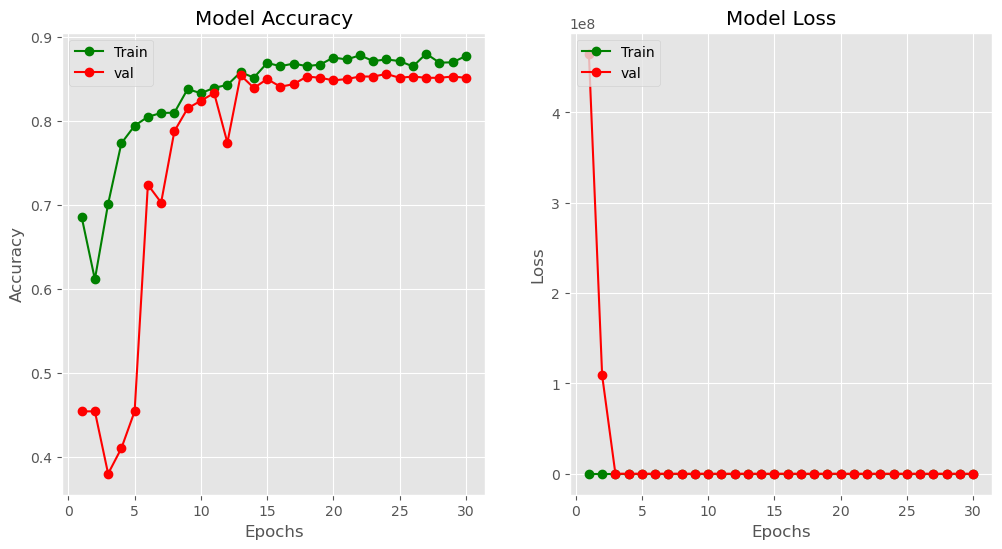

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [35]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,31)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")
#plt.show()

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

test_data.labels

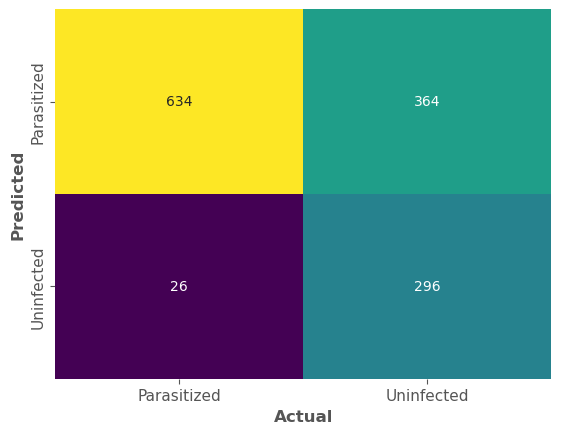

In [36]:
import seaborn as sns
cm_data = [[history.history['val_tp'][-1], history.history['val_fp'][-1]], [history.history['val_fn'][-1], history.history['val_tn'][-1]]]
sns.heatmap(cm_data, annot=True, cmap = 'viridis',cbar = False,fmt = 'g')
plt.xticks([0.5,1.5],["Parasitized","Uninfected"],fontsize=11)
plt.yticks([0.5,1.5],["Parasitized","Uninfected"],fontsize=11)
plt.xlabel("Actual",fontsize=12, fontweight="bold")
plt.ylabel("Predicted",fontsize=12, fontweight="bold")
plt.show()

In [37]:
TP = history.history['val_tp'][-1]
print("TP =", TP)
FP = history.history['val_fp'][-1]
print("FP =", FP)
TN = history.history['val_tn'][-1]
print("TN =", TN)
FN = history.history['val_fn'][-1]
print("FN =", FN)

TP = 634.0
FP = 364.0
TN = 296.0
FN = 26.0


In [38]:
FPR= (FP/(FP+TN))
TPR= (TP/(TP+FN))
print("FPR=", FPR)
print("TPR=", TPR)

FPR= 0.5515151515151515
TPR= 0.9606060606060606


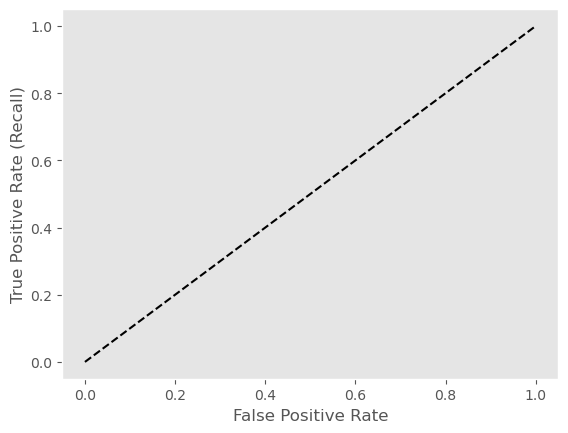

In [39]:
from sklearn.metrics import roc_curve
def plot_roc_curve (FPR, TPR, label = None):
    plt.plot(FPR, TPR, linewidth = 2, label = label)
    plt.plot([0,1], [0,1], 'k--') # Dashed diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.grid()
    
plot_roc_curve(FPR, TPR)
plt.show()


In [40]:
import tensorflow as tf
model.trainable = True
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

epochs = 20
model.fit(train_data, epochs=epochs, validation_data=test_data)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 2, 2, 2048)       0         
 g2D)                                                            
                                                                 
 batch_normalization_190 (Ba  (None, 2, 2, 2048)       8192      
 tchNormalization)                                               
                                                                 
 dropout_4 (Dropout)         (None, 2, 2, 2048)        0         
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 512)              

2023-03-22 05:14:42.653235: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


83/83 [==============================] - 75s 509ms/step - loss: 0.2914 - categorical_accuracy: 0.8692 - val_loss: 0.3520 - val_categorical_accuracy: 0.8500
Epoch 2/20
83/83 [==============================] - 42s 501ms/step - loss: 0.2870 - categorical_accuracy: 0.8771 - val_loss: 0.4984 - val_categorical_accuracy: 0.8500
Epoch 3/20
83/83 [==============================] - 41s 492ms/step - loss: 0.2881 - categorical_accuracy: 0.8775 - val_loss: 0.7040 - val_categorical_accuracy: 0.8485
Epoch 4/20
83/83 [==============================] - 41s 490ms/step - loss: 0.2885 - categorical_accuracy: 0.8737 - val_loss: 0.3686 - val_categorical_accuracy: 0.8485
Epoch 5/20
83/83 [==============================] - 42s 505ms/step - loss: 0.2845 - categorical_accuracy: 0.8749 - val_loss: 0.3483 - val_categorical_accuracy: 0.8470
Epoch 6/20
83/83 [==============================] - 41s 497ms/step - loss: 0.2828 - categorical_accuracy: 0.8749 - val_loss: 0.5168 - val_categorical_accuracy: 0.8424
Epoch 7/2

In [41]:
model.save("InceptionV3.h5")
model.evaluate(test_data)

21/21 [==============================] - 2s 108ms/step - loss: 0.9388 - categorical_accuracy: 0.8621


[0.9387733340263367, 0.8621212244033813]